In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms
from pathlib import Path
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
folder = Path('/content/drive/MyDrive/Project')
train_path = Path('/content/drive/MyDrive/Project/train')
test_path = Path('/content/drive/MyDrive/Project/test_data')

In [8]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'



import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms

In [9]:
# define transformation
data_transformer = transforms.Compose([transforms.ToTensor()])

In [10]:
mean=[0.48605457, 0.45592883, 0.39390326]
std=[0.22131737,0.2155561,0.2173404]

In [11]:
train_transformer = transforms.Compose([transforms.Resize((299,299)),
    transforms.RandomRotation(25),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.ToTensor(),
    transforms.Lambda(lambda img: torch.cat((img, img, img), axis=0) if img.shape[0] == 1 else img),
    transforms.Normalize(mean, std)])
                 

test0_transformer = transforms.Compose([transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Lambda(lambda img: torch.cat((img, img, img), axis=0) if img.shape[0] == 1 else img),
    transforms.Normalize(mean, std),
    ])

In [12]:
train_data = torchvision.datasets.ImageFolder(root=train_path,transform=train_transformer)

In [10]:
len(train_data)

9025

In [13]:
from torch.utils.data import Dataset

In [14]:
test_data = torchvision.datasets.ImageFolder(root=test_path,transform=data_transformer)

In [15]:
print("Number of train samples: ", len(train_data))
print("Number of test samples: ", len(test_data))
print("Detected Classes are: ", train_data.class_to_idx) # classes are detected by folder structure

Number of train samples:  9025
Number of test samples:  3929
Detected Classes are:  {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


In [16]:
# Import libraries
import torch, torchvision
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
import collections
from time import time
from sklearn.metrics import accuracy_score
from torchvision import models
import torch
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
import copy

def identify_device():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)
    return device

# helper function to show images
def imgshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# A helper function to count the number of correct predictions per data batch:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

# A helper function to compute the loss value per batch of data:
def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# a helper function to compute the loss value and the performance metric for the entire dataset or an epoch.
def loss_epoch(device,model,loss_func,dataset_dl,sanity_check=False,opt=None):
    device = device
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # changed output to output[0]
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

def train_val(device,model, params):
    # extract model parameters
    device=device
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_loader=params["train_loader"]
    valid_loader=params["valid_loader"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in range(num_epochs):
        epoch_start_time = time()
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(device,model,loss_func,train_loader,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(device,model,loss_func,valid_loader,sanity_check)
        epoch_end_time = time()
        epoch_total_time = epoch_end_time - epoch_start_time
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step()

        print("train loss: %.6f, valid loss: %.6f, train accuracy: %.2f, valid accuracy: %.2f, time: %.2f" %(train_loss,val_loss,100*train_metric,100*val_metric,epoch_total_time))
        print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

def deploy_model(model,dataset,device, num_classes=10,sanity_check=False):

    len_data=len(dataset)
    
    # initialize output tensor on CPU: due to GPU memory limits
    y_out=torch.zeros(len_data,num_classes)
    
    # initialize ground truth on CPU: due to GPU memory limits
    y_gt=np.zeros((len_data),dtype="uint8")
    
    # move model to device
    model=model.to(device)
    
    elapsed_times=[]
    with torch.no_grad():
        for i in range(len_data):
            x,y=dataset[i]
            y_gt[i]=y
            start=time()    
            yy=model(x.unsqueeze(0).to(device))
            y_out[i]=torch.softmax(yy,dim=1)
            elapsed=time()-start
            elapsed_times.append(elapsed)

            if sanity_check is True:
                break

    inference_time=np.mean(elapsed_times)*1000
    print("average inference time per image on %s: %.2f ms " %(device,inference_time))
    return y_out.numpy(),y_gt
def loss_accuracy_plots(params_train, loss_hist, metric_hist):
    # Train-Validation Progress
    num_epochs=params_train["num_epochs"]

    # plot loss progress
    plt.title("Train-Val Loss")
    plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    # plot accuracy progress
    plt.title("Train-Val Accuracy")
    plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true,y_pred,normalize=None):
  cm=confusion_matrix(y_true,y_pred,normalize=normalize)
  fig, ax = plt.subplots(figsize=(6,5))
  if normalize == None:
    fmt='d'
    fig.suptitle('Confusion matrix without Normalization', fontsize=12)
        
  else :
    fmt='0.2f'
    fig.suptitle('Normalized confusion matrix', fontsize=12)
    
  ax=sns.heatmap(cm,cmap=plt.cm.Blues,annot=True,fmt=fmt)
  ax.axhline(y=0, color='k',linewidth=1)
  ax.axhline(y=cm.shape[1], color='k',linewidth=2)
  ax.axvline(x=0, color='k',linewidth=1)
  ax.axvline(x=cm.shape[0], color='k',linewidth=2)
 
  ax.set_xlabel('Predicted label', fontsize=12)
  ax.set_ylabel('True label', fontsize=12)

In [17]:
#from helpers import identify_device, imgshow, get_lr, metrics_batch, loss_batch, loss_epoch, train_val, deploy_model, loss_accuracy_plots,plot_confusion_matrix 
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
import collections
import matplotlib.pyplot as plt
import torch, torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import models
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import StepLR
from torch import optim
import numpy as np
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset

In [19]:
device = identify_device()

cuda:0


In [20]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
indices=list(range(len(train_data)))
y_train0=[y for _,y in train_data]

In [21]:
for train_index, valid_index in sss.split(indices, y_train0):
    print("train:", train_index, "val:", valid_index)
    print(len(train_index),len(valid_index))

train: [1839 3574 3909 ... 7933 2329 2936] val: [7430 3522  388 ... 1715 2598 2489]
7220 1805


In [22]:
train_dataset = Subset(train_data, indices=train_index)
valid_dataset = Subset(train_data, indices=valid_index)

In [23]:
# Count of each target class in train and valid
y_train=[y for _,y in train_dataset]
y_valid=[y for _,y in valid_dataset]

counter_train=collections.Counter(y_train)
counter_val=collections.Counter(y_valid)
sorted_train_counter = sorted(counter_train.items())
sorted_valid_counter = sorted(counter_val.items())

In [24]:
print(f'Train : {sorted_train_counter}')
print(f'Valid : {sorted_valid_counter}')

Train : [(0, 753), (1, 742), (2, 737), (3, 746), (4, 464), (5, 752), (6, 754), (7, 759), (8, 754), (9, 759)]
Valid : [(0, 188), (1, 186), (2, 184), (3, 186), (4, 116), (5, 188), (6, 189), (7, 190), (8, 188), (9, 190)]


In [25]:
total = len(train_dataset)
weights = []
for item in sorted_train_counter:
    weight = total/(10*item[1])
    weights.append(weight)
print(weights)

[0.9588313413014609, 0.9730458221024259, 0.9796472184531886, 0.967828418230563, 1.5560344827586208, 0.9601063829787234, 0.9575596816976127, 0.9512516469038208, 0.9575596816976127, 0.9512516469038208]


In [26]:
weights_tensor = torch.tensor(weights).to(device)

In [27]:
# overwrite the transform functions
# Note that when we update the test0_ds.transform function, both val_ds, 
# and test_ds will be updated since they are subsets of test0_ds.
train_data.transform=train_transformer
test_data.transform=test0_transformer

In [28]:
torch.manual_seed(0)

train_idx = indices=list(range(len(train_dataset)))
valid_idx = indices=list(range(len(valid_dataset)))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)#imblance
valid_sampler = SubsetRandomSampler(valid_idx)

In [29]:
batch_size=16
train_loader= torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader= torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, sampler=valid_sampler)
torch.manual_seed(0)
#test_loader= torch.utils.data.DataLoader(dataset=test_data,
                                        #batch_size=batch_size,
                                        #shuffle=False
                                        #)

In [30]:
# Shape of training batch
dataiter = iter(train_loader)
train_images, train_labels = dataiter.next()

print('Training data:')
print('X shape:',train_images.shape)
print('y shape:',train_labels.shape)

Training data:
X shape: torch.Size([16, 3, 299, 299])
y shape: torch.Size([16])


In [31]:
# Shape of validation batch
dataiter = iter(valid_loader)
valid_images, valid_labels = dataiter.next()

print('Validation data:')
print('X shape:',valid_images.shape)
print('y shape:',valid_labels.shape)

Validation data:
X shape: torch.Size([16, 3, 299, 299])
y shape: torch.Size([16])


image indices: [2732 2607 1653 3264]
torch.Size([3, 303, 1206])


<Figure size 720x720 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


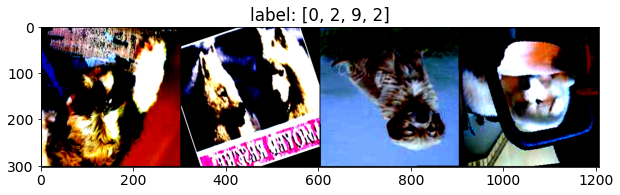

In [32]:
import torch
np.random.seed(0)
torch.manual_seed(0)
def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))

# make a grid
grid_size=4
rnd_inds=np.random.randint(0,len(train_dataset),grid_size)
print("image indices:",rnd_inds)

x_grid=[train_dataset[i][0] for i in rnd_inds]
y_grid=[train_dataset[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

In [33]:
# upload model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [34]:
from torchvision import models
import torch

# load model with pretrained weights
resnet50_pretrained = models.resnet50(pretrained=True)

# change the output layer
num_classes=10
num_ftrs = resnet50_pretrained.fc.in_features
resnet50_pretrained.fc = nn.Linear(num_ftrs, num_classes)

#device = torch.device("cuda:0")
resnet50_pretrained.to(device) 

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

torch.Size([64, 3, 7, 7])
2.9802322387695312e-08 0.9998041391372681
torch.Size([3, 65, 65])


<Figure size 360x360 with 0 Axes>

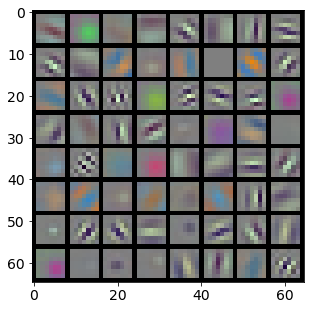

In [35]:
# get Conv1 weights
for w in resnet50_pretrained.parameters():
    w=w.data.cpu()
    print(w.shape)
    break

# normalize to [0,1]
min_w=torch.min(w)
w1 = (-1/(2*min_w))*w + 0.5 
print(torch.min(w1).item(),torch.max(w1).item())

# make a grid
grid_size=len(w1)
x_grid=[w1[i] for i in range(grid_size)]
x_grid=utils.make_grid(x_grid, nrow=8, padding=1)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(5,5))
show(x_grid)

In [36]:
loss_func = nn.CrossEntropyLoss(reduction="sum")

In [37]:
from torch import optim
opt = optim.Adam(resnet50_pretrained.parameters(), lr=1e-4)

In [38]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0001


In [39]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# define learning rate scheduler
# Several methods exist to adjust the learning rate. For a list of supported methods by PyTorch, 
# please visit the following link: https://pytorch.org/docs/stable/optim.html.
lr_scheduler = CosineAnnealingLR(opt,T_max=2,eta_min=1e-5)

In [40]:
lrs=[]
for i in range(10):
    lr_scheduler.step()
    lr=get_lr(opt)
    print("epoch %s, lr: %.1e" %(i,lr))
    lrs.append(lr)

epoch 0, lr: 5.5e-05
epoch 1, lr: 1.0e-05
epoch 2, lr: 5.5e-05
epoch 3, lr: 1.0e-04
epoch 4, lr: 5.5e-05
epoch 5, lr: 1.0e-05
epoch 6, lr: 5.5e-05
epoch 7, lr: 1.0e-04
epoch 8, lr: 5.5e-05
epoch 9, lr: 1.0e-05


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [41]:
# A helper function to count the number of correct predictions per data batch:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [42]:
# A helper function to compute the loss value per batch of data:
def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [43]:
# a helper function to compute the loss value and the performance metric for the entire dataset or an epoch.

# define device as a global variable
#device = torch.device("cuda")

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

In [44]:
# a helper function to compute the loss value and the performance metric for the entire dataset or an epoch.

# define device as a global variable
#device = torch.device("cuda")

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

In [45]:
def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_loader=params["train_loader"]
    valid_loader=params["valid_loader"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in range(num_epochs):
        
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_loader,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,valid_loader,sanity_check)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step()

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [46]:
import copy

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(resnet50_pretrained.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)

params_train={
 "num_epochs": 7,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_loader": train_loader,
 "valid_loader": valid_loader,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "resnet50_pretrained.pt",
}

# train and validate the model
resnet50_pretrained,loss_hist,metric_hist=train_val(resnet50_pretrained,params_train)

Epoch 0/6, current lr=0.0001
Copied best model weights!
train loss: 0.832127, dev loss: 0.619107, accuracy: 79.61
----------
Epoch 1/6, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.534606, dev loss: 0.422210, accuracy: 86.70
----------
Epoch 2/6, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.391534, dev loss: 0.365473, accuracy: 87.04
----------
Epoch 3/6, current lr=3.52036587784401e-05
Copied best model weights!
train loss: 0.269468, dev loss: 0.311023, accuracy: 89.70
----------
Epoch 4/6, current lr=1.0453658778440105e-05
Copied best model weights!
train loss: 0.183182, dev loss: 0.253240, accuracy: 91.52
----------
Epoch 5/6, current lr=1e-06
train loss: 0.162407, dev loss: 0.256523, accuracy: 91.86
----------
Epoch 6/6, current lr=1.0453658778440102e-05
train loss: 0.155054, dev loss: 0.253255, accuracy: 91.30
----------


In [47]:
import torch 

# load state_dict into model
path2weights=folder / "resnet50_pretrained.pt"
resnet50_pretrained.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [ ]:
# set model in evaluation mode
#resnet50_pretrained.eval();

In [48]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    resnet50_pretrained=resnet50_pretrained.to(device)

In [49]:
def get_predictions(imgPath, model):
    img = Image.open(imgPath).convert('RGB')
    img = test0_transformer(img)
    #img = np.expand_dims(img, 0)
    #img = torch.from_numpy(img)
    #img = torch.unsqueeze(img, 0)
    img = img.view(1, 3, 299, 299)
    
    model.eval()
    inputs = Variable(img).to(device)
    output = model(inputs)
    _,pred = torch.max(output,dim=1)
    
    return pred.cpu().numpy()

In [52]:
path = folder
path2= folder/'test_data'/'test_combined'
sampleSubmission = pd.read_csv(folder / 'sample_submission.csv')
temp = list()
for i in range(len(sampleSubmission)):
    imgName = '{}'.format(sampleSubmission.iloc[i, 0])
    fullName = os.path.join(path2 /imgName)
    pred = get_predictions(fullName, resnet50_pretrained)
    temp.append({'file_names': imgName, 'target': pred[0]})
    
df = pd.DataFrame(temp)
df.to_csv(path / 'Group_6_submission.csv', index=False)

In [51]:
ls

drive/  sample_data/
